# Background

#### Playground competition: [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection)

This kernel was created for a data-science project at the University of Salzburg in collaboration with my collegue [Marcel](https://www.kaggle.com/msteger93). Check out his version of our kernel [here](https://www.kaggle.com/msteger93/best-swagoverflowkernel-clr)!

#### Architecture

We used the [densenet121 implemenation](https://github.com/pytorch/vision/blob/master/torchvision/models/densenet.py) of the  [DenseNet architecture](https://arxiv.org/abs/1608.06993) and made a couple of changes to adapt it for the use-case at hand.

#### Data

At first, we tried using only the center 32x32 region because we thought that maybe only the region (possibly) containing tumor tissue is relevant (see [PCAM data-set description](https://github.com/basveeling/pcam)). An advantage of this approach would have been that the cropped dataset fits into memory and would allow faster training and experimentation. Unfortunately, the performance turned out to be lower than with the full images so we reverted to using the full images again.

**Data Augmentation**:

The Data is inherently rotation-equivariant as described in the [paper](https://arxiv.org/abs/1806.03962) written by the Benchmark-creators. Simply put: if you rotate an image by a random number of degrees, it still looks like any other image and is an equally valid training example.

For this reason, we added random rotations and random horizontal flips as data augementation to increase the diversity of the training set.



In [1]:
import os
import time
from tqdm import tqdm

from collections import OrderedDict

import numpy as np
from numpy.random import choice
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import PIL

from sklearn.metrics import roc_auc_score

import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision

np.random.seed(42)

# Load data

For experimenting, it's convenient to use only a subset of the dataset (up to 50k) and load it into memory. It takes a few minutes to load but greatly speeds up the training processes and allows to quicky examine different hyperparameter settings.

As the whole data-set doesn't fit into memory, it has to read from disk and training takes too long for interactive sessions => only for commiting the kernel.

In [2]:
DATA_DIR = '../input'
train_dir = os.path.join(DATA_DIR, 'train')
test_dir  = os.path.join(DATA_DIR, 'test')


def train_validation_split(df, val_fraction=0.1):
    val_ids  = np.random.choice(df.id, size=int(len(df) * val_fraction))
    val_df   = df.query('id     in @val_ids')
    train_df = df.query('id not in @val_ids')
    return train_df, val_df


train_label_df, val_label_df = train_validation_split(pd.read_csv(os.path.join(DATA_DIR, 'train_labels.csv')),
                                                      val_fraction=0.1)

In [3]:
def function_timer(function):
    
    def wrapper(*args, **kwargs):
        start    = time.time()
        result   = function(*args, **kwargs)
        duration = time.time() - start
        
        hours    = int(duration // 60**2)
        minutes  = int((duration % 60**2) // 60)  
        seconds  = int(duration % 60)
        print(f'execution-time of function "{function.__name__}": {hours}h {minutes}m {seconds}s')
        
        return result
        
    return wrapper


class HistoPatches(Dataset):
    
    def __init__(self,
                 image_dir: str,
                 label_df=None,
                 transform=transforms.ToTensor(),
                 sample_n=None,
                 in_memory=False):
        """
        @ image_dir:   path to directory with images
        @ label_df:    df with image id (str) and label (0/1) - only for labeled test-set
        @ transforms:  image transformation; by default no transformation
        @ sample_n:    if not None, only use that many observations
        """
        self.image_dir = image_dir
        self.label_df  = label_df
        self.transform = transform
        self.in_memory = in_memory
        
        if label_df is not None:
            if sample_n:
                self.label_df = self.label_df.sample(n=sample_n)
            ids = set(self.label_df.id)
            self.img_files = [f for f in os.listdir(image_dir) if f.split('.')[0] in ids]
        else:
            if sample_n is not None:
                print('subsampling is currently only implemented when a label-dataframe is provided.')
                return
            self.img_files = os.listdir(image_dir)
        
        if in_memory:
            self.id2image = self._load_images()

        print(f'Initialized datatset with {len(self.img_files)} images.\n')
        
    @function_timer
    def _load_images(self):
        print('loading images in memory...')
        id2image = {}
        
        for file_name in self.img_files:
            img = PIL.Image.open(os.path.join(self.image_dir, file_name))
            X   = self.transform(img)
            id_ = file_name.split('.')[0]
            id2image[id_] = X
            
        return id2image
    
    def __getitem__(self, idx):
        file_name = self.img_files[idx]
        id_ = file_name.split('.')[0]
        
        if self.in_memory:
            X = self.id2image[id_]
        else:
            img = PIL.Image.open(os.path.join(self.image_dir, file_name))
            X   = self.transform(img)
            
        if self.label_df is not None:
            y = float(self.label_df.query('id == @id_').label)
            return X, y
        else:
            return X, id_
    
    def __len__(self):
        return len(self.img_files)

    
memory      = False
batchsize   = 64
image_trans = transforms.Compose([#transforms.CenterCrop(30),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.70017236, 0.5436771, 0.6961061], 
                                                       std=[0.22246036, 0.26757348, 0.19798167])
                                ])
train_trans = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.70017236, 0.5436771, 0.6961061], 
                                                       std=[0.22246036, 0.26757348, 0.19798167]),
                                  transforms.RandomRotation((-180, 180)),
                                  transforms.RandomHorizontalFlip()])
                                 
train = HistoPatches(train_dir,
                     train_label_df,
                     transform=image_trans,
                     #sample_n=1000,
                     in_memory=memory)

val   = HistoPatches(train_dir,
                     val_label_df,
                     transform=image_trans,
                     #sample_n=100,
                     in_memory=memory)

train_loader = DataLoader(train, batch_size=batchsize, shuffle=True)
val_loader   = DataLoader(val,   batch_size=batchsize, shuffle=False)

X, y = next(iter(train_loader))
print('batch-dimensions: ', X.shape, y.shape)

Initialized datatset with 199075 images.

Initialized datatset with 20950 images.

batch-dimensions:  torch.Size([64, 3, 96, 96]) torch.Size([64])


# Architecture adaptation

### [densenet121 architecture](https://github.com/pytorch/vision/blob/master/torchvision/models/densenet.py)

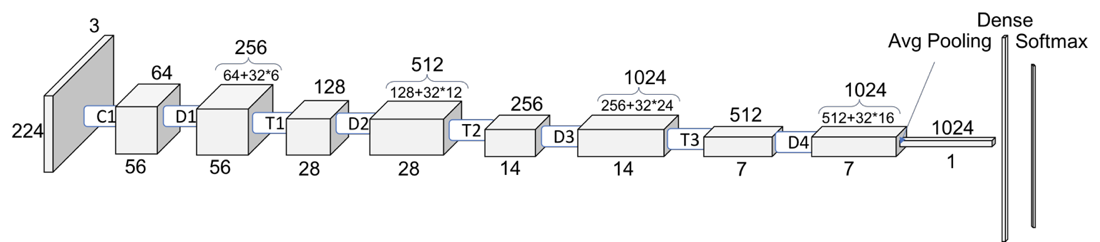

In [4]:
def conv_dim(in_dim, k=3, s=1, p=0, p_left=None, p_right=None):
    """
    Helper function for interactively checking output-dimensions of conv-layers.
    """
    if p is not None:
        p_left = p_right = p
    assert p_left is not None and p_right is not None
        
    tmp = (in_dim - k + p_left + p_right) / s
    out_dim = int(np.floor(tmp) + 1)
    
    if tmp % 1 != 0:
        print('no exact output-dim; using Gauss-brackets.')
    print(f'out-dim: {out_dim}')


conv_dim(30, k=3, s=1, p=0)

out-dim: 28


The densenet121 architecture expects 224x224 input images and has 1000 output neurons (for the 1000 classes of ImageNet). For the PCAM dataset, we need to adapt the first part of the conv-net for the 96x96 images. In short, we just need less downsampling. Instead of using one large-kernel (7x7), stride=2 convolution as well as max-pooling layer, we only use one stride=2 convolution which downsamples the feature-maps to half the resolution (48x48). The four dense-blocks are left unchange. Finally, of course the classifier hast to be exchanged for a binary classifier. We chose to try a two-layer MLP instead of a single fully connected layer although it probably doesn't make much difference.

In [5]:
net = models.densenet121(pretrained=False)
net.features = nn.Sequential(
    nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)),
            ('norm0', nn.BatchNorm2d(64)),
            ('relu0', nn.ReLU(inplace=True))
        ])),  # 96**2 -> 48**2
    net.features[4:])

net.classifier = nn.Sequential(
    nn.Linear(1024, 512),
    nn.Dropout(p=0.1),
    nn.ReLU(),
    nn.Linear(512, 1)
)

Check the architecture by processing a single batch:

In [6]:
myloss = nn.BCEWithLogitsLoss()
net.cuda()
X, y = next(iter(train_loader))
X , y = X.cuda(), y.cuda()
print('X, y shapes: ', X.shape, y.shape)
out = net(X).squeeze()
print(f'loss: {myloss(y, out.type(torch.DoubleTensor).cuda()).item()}')

X, y shapes:  torch.Size([64, 3, 96, 96]) torch.Size([64])
loss: 0.9761259823132621


# Train model

In [7]:
@function_timer
def train_model(net, train, validation, optimizer, device, max_epoch=100, verbose=False):
    """
    This function returns nothing. The parametes of @net are updated in-place
    and the error statistics are written to a global variable. This allows to
    stop the training at any point and still have the results.
  
    @ net: a defined model - can also be pretrained
    @ train, test: DataLoaders of training- and test-set
    @ max_epoch: stop training after this number of epochs
    """
    global error_df  # to track error log even when training aborted
    error_df = pd.DataFrame(columns=['train_bce', 'train_acc', 'train_auc', 'val_bce', 'val_acc', 'val_auc'])
  
    criterion = nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    net.to(device)
  
    print('epoch\tLR\ttr-BCE\ttr-Acc\ttr-AUC\t\tval-BCE\tval-Acc\tval-AUC')
    for epoch in range(max_epoch):
        net.train()
        training_bce = training_acc = training_auc = 0
    
        for X, y in train:
            
            X , y = X.to(device), y.to(device)
            optimizer.zero_grad()

            # prediction and error:
            out  = net(X).squeeze()
            
            labels = y.detach().cpu().numpy()
            probabilities = torch.sigmoid(out).detach().cpu().numpy()
            predictions = probabilities.round()
            loss = criterion(out.type(torch.DoubleTensor).cuda(), y)
            
            training_bce += loss.item()
            training_acc += np.mean(labels == predictions) * 100
            training_auc += roc_auc_score(y_true=labels, y_score=probabilities)

            # update parameters:
            loss.backward()
            optimizer.step()

        with torch.no_grad():  # no backpropagation necessary
            net.eval()
            validation_bce = validation_acc = validation_auc = 0

            for X, y in validation:
                X , y = X.to(device), y.to(device)

                # prediction and error:
                out  = net(X).squeeze()

                labels = y.detach().cpu().numpy()
                probabilities = torch.sigmoid(out).detach().cpu().numpy()
                predictions = probabilities.round()

                validation_bce += criterion(out.type(torch.DoubleTensor).cuda(), y).item()
                validation_acc += np.mean(labels == predictions) * 100
                validation_auc += roc_auc_score(y_true=labels, y_score=probabilities)
    
        # convert to batch loss:
        training_bce   /= len(train)
        training_acc   /= len(train)
        training_auc   /= len(train)
        
        validation_bce /= len(validation)
        validation_acc /= len(validation)
        validation_auc /= len(validation)
        scheduler.step()
       
        #torch.save(net.state_dict(), f'epoch{epoch}.pt')
        error_stats = [training_bce, training_acc, training_auc, validation_bce, validation_acc, validation_auc]
        error_df = error_df.append(pd.Series(error_stats, index=error_df.columns), ignore_index=True)
        print('{}\t{:.4f}\t{:.4f}\t{:.2f}\t{:.4f}\t\t{:.4f}\t{:.2f}\t{:.4f}'.format(epoch, optimizer.param_groups[0]['lr'], *error_stats))

In [8]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=0)  #5e-6)

train_model(net,
            train_loader,
            val_loader,
            optimizer,
            device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
            max_epoch=9,
            verbose=False)
torch.save(net.state_dict(), 'swag_net.pt')

epoch	LR	tr-BCE	tr-Acc	tr-AUC		val-BCE	val-Acc	val-AUC
0	0.0090	0.3394	85.89	0.9327		0.2550	89.51	0.9589
1	0.0081	0.2314	90.97	0.9690		0.2199	91.16	0.9690
2	0.0073	0.1824	93.15	0.9803		0.1557	94.17	0.9844
3	0.0066	0.1547	94.27	0.9858		0.2117	91.82	0.9844
4	0.0059	0.1349	95.08	0.9887		0.1308	95.21	0.9885
5	0.0053	0.1194	95.72	0.9912		0.1267	95.26	0.9898
6	0.0048	0.1059	96.27	0.9929		0.1203	95.82	0.9900
7	0.0043	0.0953	96.69	0.9942		0.1005	96.37	0.9929
8	0.0039	0.0846	97.06	0.9954		0.1085	96.25	0.9918
execution-time of function "train_model": 8h 4m 11s


# Results and inference

In [9]:
def predict_and_display(net, testset, n=10):
    """
    Predict @n random examples from the test-set and show images + predictions
    """
    net.eval()
    for i in choice(range(len(testset)), size=n):
        image, label = test_set[i]
        output = net(image.unsqueeze(0).cuda())
        prob, pred = prediction_from_output(output.unsqueeze(0))
        prob, pred = prob.item(), pred.item()
        evaluation = 'correct' if pred == label else 'mistake'

        plt.figure( figsize=(2, 2) )
        print(f'\ntruth: {label} | pred: {pred} | prob: {prob:.2f}')
        print(f'{evaluation}: ({class_name(label)} vs. {class_name(pred)})')
        show_image(image, means=channel_means, stdevs=channel_standard_devs)


def plot_error_curves(training_error, validation_error, error_name='error', ylim=None, save_fig=True):
    """
    @ errors_over_time: list of tuples: (training-error, validation-error)
    """
    assert len(training_error) == len(validation_error) > 1
    
    fig, ax = plt.subplots()
    ax.plot(range(len(training_error)), training_error)
    ax.plot(range(len(validation_error)), validation_error)
    
    if ylim:
        ax.set_ylim(*ylim)
    
    ax.set_xlabel('epoch')
    ax.set_ylabel('CE')
    ax.legend(('training', 'validation'))
    ax.set_title(f'{error_name} over time')
    
    if save_fig:
        fig.savefig(f'{error_name.replace(" ", "_")}_learning_curve', bbox_inches='tight', transparent=True)
    
    plt.show();

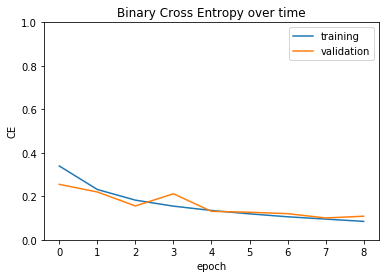

In [10]:
plot_error_curves(error_df.train_bce, error_df.val_bce, error_name='Binary Cross Entropy', ylim=(0, 1))

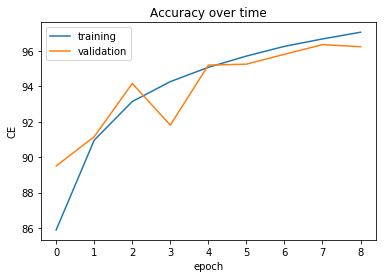

In [11]:
plot_error_curves(error_df.train_acc, error_df.val_acc, error_name='Accuracy')

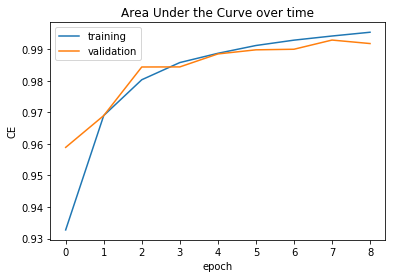

In [12]:
plot_error_curves(error_df.train_auc, error_df.val_auc, error_name='Area Under the Curve')

## Make predictions
If all the memory is used up during training, the kernel frequently crashes when making the predictions. For this reason, we calculate the predictions only on the CPU even though it takes a while.

In [13]:
def write_submission_file():
    test = HistoPatches(image_dir=os.path.join(DATA_DIR, 'test'), transform=image_trans)
    test_loader = DataLoader(test, batch_size=16)
    prediction_df = pd.DataFrame(columns=['id', 'label'])

    for i, (X, ids) in enumerate(test_loader):

        out = net(X.cuda()).squeeze()
        probabilities = torch.sigmoid(out).detach().cpu().numpy()
        df = pd.DataFrame({'id': ids, 'label': probabilities})
        prediction_df = prediction_df.append(df)

    display(prediction_df.head())
    prediction_df.to_csv('submission.csv', index=False)
    os.listdir('.')


write_submission_file()

Initialized datatset with 57458 images.



,id,label
0,485b548a7ee70df49fe7cab6d7062fb8d8f172aa,0.033053
1,0a13be637bd66856953494747e1a56e11e394acc,0.014183
2,1d19c0a74340c60c31b677a0032e710886645bc6,0.021977
3,f45110c8ce329fc4292c2dfb93f1bc73b31d0919,0.999997
4,e07ddd315e3037431689b18b3631c756a7220102,0.014432


**Download for interactive session:**  
<a href="submission.csv"> submission-file </a>   
<a href="swag_net"> net parameters</a>  